## Demons Registration Demos
### Preparation

In [1]:
import numpy as np
import itk
from itkwidgets import view
from matplotlib import pyplot as plt
from time import time
%matplotlib inline
from ipywidgets import interact

In [2]:
PixelType = itk.ctype('float')
fixed_image = itk.imread('data/BrainProtonDensitySliceBorder20.png', PixelType)
moving_image = itk.imread('data/BrainProtonDensitySliceShifted13x17y.png', PixelType)

In [3]:
import SimpleITK as sitk

def multiscale_demons(registration_algorithm,
                      fixed_image, moving_image, initial_transform = None, 
                      shrink_factors=None, smoothing_sigmas=None):
    """
    Run the given registration algorithm in a multiscale fashion. The original scale should not be given as input as the
    original images are implicitly incorporated as the base of the pyramid.
    Args:
        registration_algorithm: Any registration algorithm that has an Execute(fixed_image, moving_image, displacement_field_image)
                                method.
        fixed_image: Resulting transformation maps points from this image's spatial domain to the moving image spatial domain.
        moving_image: Resulting transformation maps points from the fixed_image's spatial domain to this image's spatial domain.
        initial_transform: Any SimpleITK transform, used to initialize the displacement field.
        shrink_factors (list of lists or scalars): Shrink factors relative to the original image's size. When the list entry, 
                                                   shrink_factors[i], is a scalar the same factor is applied to all axes.
                                                   When the list entry is a list, shrink_factors[i][j] is applied to axis j.
                                                   This allows us to specify different shrink factors per axis. This is useful
                                                   in the context of microscopy images where it is not uncommon to have
                                                   unbalanced sampling such as a 512x512x8 image. In this case we would only want to 
                                                   sample in the x,y axes and leave the z axis as is: [[[8,8,1],[4,4,1],[2,2,1]].
        smoothing_sigmas (list of lists or scalars): Amount of smoothing which is done prior to resmapling the image using the given shrink factor. These
                          are in physical (image spacing) units.
    Returns: 
        SimpleITK.DisplacementFieldTransform
    """
    # Create image pyramid.
    fixed_images = [fixed_image]
    moving_images = [moving_image]
    if shrink_factors:
        for shrink_factor, smoothing_sigma in reversed(list(zip(shrink_factors, smoothing_sigmas))):
            fixed_images.append(smooth_and_resample(fixed_images[0], shrink_factor, smoothing_sigma))
            moving_images.append(smooth_and_resample(moving_images[0], shrink_factor, smoothing_sigma))
    
    # Create initial displacement field at lowest resolution. 
    # Currently, the pixel type is required to be sitkVectorFloat64 because of a constraint imposed by the Demons filters.
    if initial_transform:
        initial_displacement_field = sitk.TransformToDisplacementField(initial_transform, 
                                                                       sitk.sitkVectorFloat64,
                                                                       fixed_images[-1].GetSize(),
                                                                       fixed_images[-1].GetOrigin(),
                                                                       fixed_images[-1].GetSpacing(),
                                                                       fixed_images[-1].GetDirection())
    else:
        initial_displacement_field = sitk.Image(fixed_images[-1].GetWidth(), 
                                                fixed_images[-1].GetHeight(),
                                                fixed_images[-1].GetDepth(),
                                                sitk.sitkVectorFloat64)
        initial_displacement_field.CopyInformation(fixed_images[-1])
 
    # Run the registration.            
    initial_displacement_field = registration_algorithm.Execute(fixed_images[-1], 
                                                                moving_images[-1], 
                                                                initial_displacement_field)
    # Start at the top of the pyramid and work our way down.    
    for f_image, m_image in reversed(list(zip(fixed_images[0:-1], moving_images[0:-1]))):
            initial_displacement_field = sitk.Resample (initial_displacement_field, f_image)
            initial_displacement_field = registration_algorithm.Execute(f_image, m_image, initial_displacement_field)
    return sitk.DisplacementFieldTransform(initial_displacement_field)

In [4]:
from time import time
t0 = time()
# Define a simple callback which allows us to monitor the Demons filter's progress.
def iteration_callback(filter):
    print('\r{0}: {1:.2f}'.format(filter.GetElapsedIterations(), filter.GetMetric()), end='')


# Select a Demons filter and configure it.
demons_filter =  sitk.FastSymmetricForcesDemonsRegistrationFilter()
demons_filter.SetNumberOfIterations(500)
# Regularization (update field - viscous, total field - elastic).
demons_filter.SetSmoothDisplacementField(True)
demons_filter.SetStandardDeviations(3.0)
# Add our simple callback to the registration filter.
# demons_filter.AddCommand(sitk.sitkIterationEvent, lambda: iteration_callback(demons_filter))
fixed_image2 = sitk.ReadImage('data/BrainProtonDensitySliceBorder20.png', sitk.sitkFloat32)
moving_image2 = sitk.ReadImage('data/BrainProtonDensitySliceShifted13x17y.png', sitk.sitkFloat32)

initial_tfm = sitk.CenteredTransformInitializer(fixed_image2, 
                                                moving_image2, 
                                                sitk.Euler2DTransform(), 
                                                sitk.CenteredTransformInitializerFilter.GEOMETRY)

# Run the registration.
tx = multiscale_demons(registration_algorithm=demons_filter, 
                       fixed_image = fixed_image2, 
                       moving_image = moving_image2,
                       initial_transform = initial_tfm
                       )
print(time()-t0)

10.036747694015503


In [5]:
resample = sitk.ResampleImageFilter()
# resample.UseReferenceImage('on')
resample.SetReferenceImage(fixed_image2)
resample.SetInterpolator(sitk.sitkLinear)  
resample.SetTransform(tx)
resampled_moving_image = resample.Execute(moving_image2)
array = sitk.GetArrayViewFromImage(resampled_moving_image)

In [6]:
def DemonsRegistration(fixed, moving, iterations, Reg):
    initial_tfm = sitk.CenteredTransformInitializer(fixed, 
                                                moving, 
                                                sitk.Euler2DTransform(), 
                                                sitk.CenteredTransformInitializerFilter.GEOMETRY)
#     demons_filter =  sitk.DiffeomorphicDemonsRegistrationFilter()
    demons_filter =  sitk.FastSymmetricForcesDemonsRegistrationFilter()
    demons_filter.SetNumberOfIterations(iterations)
    # Regularization (update field - viscous, total field - elastic).
    demons_filter.SetSmoothDisplacementField(True)
    demons_filter.SetStandardDeviations(Reg)

    # Run the registration.
    tx = multiscale_demons(registration_algorithm=demons_filter, 
                           fixed_image = fixed, 
                           moving_image = moving,
                           initial_transform = initial_tfm
                           )
    resample = sitk.ResampleImageFilter()
    # resample.UseReferenceImage('on')
    resample.SetReferenceImage(fixed)
    resample.SetInterpolator(sitk.sitkLinear)  
    resample.SetTransform(tx)
    resampled_moving = resample.Execute(moving)
    return resampled_moving

In [7]:
def DemonsRegistration3D(fixed, moving, iterations, Reg, trans=False):
    initial_tfm = sitk.CenteredTransformInitializer(fixed, 
                                                moving, 
                                                sitk.Euler3DTransform(), 
                                                sitk.CenteredTransformInitializerFilter.GEOMETRY)
#     demons_filter =  sitk.DiffeomorphicDemonsRegistrationFilter()
    demons_filter =  sitk.FastSymmetricForcesDemonsRegistrationFilter()
    demons_filter.SetNumberOfIterations(iterations)
    # Regularization (update field - viscous, total field - elastic).
    demons_filter.SetSmoothDisplacementField(True)
    demons_filter.SetStandardDeviations(Reg)

    # Run the registration.
    tx = multiscale_demons(registration_algorithm=demons_filter, 
                           fixed_image = fixed, 
                           moving_image = moving,
                           initial_transform = initial_tfm
                           )
    resample = sitk.ResampleImageFilter()
    # resample.UseReferenceImage('on')
    resample.SetReferenceImage(fixed)
    resample.SetInterpolator(sitk.sitkLinear)  
    resample.SetTransform(tx)
    resampled_moving = resample.Execute(moving)
    if trans==True:
        return resampled_moving, tx
    return resampled_moving

In [31]:
def RigidRegistration2(fixed_image, moving_image, iterations):
    initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                          moving_image, 
                                                          sitk.Euler2DTransform(), 
                                                          sitk.CenteredTransformInitializerFilter.GEOMETRY)
    
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(learningRate=0.1, numberOfIterations=iterations, convergenceMinimumValue=1e-4, convergenceWindowSize=20)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    # Connect all of the observers so that we can perform plotting during registration.
#     registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
#     registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
#     registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
#     registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

    final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                   sitk.Cast(moving_image, sitk.sitkFloat32))
    resample = sitk.ResampleImageFilter()
    # resample.UseReferenceImage('on')
    resample.SetReferenceImage(fixed_image)
    resample.SetInterpolator(sitk.sitkLinear)  
    resample.SetTransform(final_transform)
    resampled_moving = resample.Execute(moving_image)
    return resampled_moving

In [8]:
def RigidRegistration(fixed_image, moving_image, iterations):
    fixed_image = itk.image_from_array(fixed_image)
    moving_image = itk.image_from_array(moving_image)
    Dimension = fixed_image.GetImageDimension()
    FixedImageType = type(fixed_image)
    MovingImageType = type(moving_image)
    print(FixedImageType,MovingImageType)
    TransformType = itk.TranslationTransform[itk.D, Dimension]
    initial_transform = TransformType.New()

    optimizer = itk.RegularStepGradientDescentOptimizerv4.New(
            learning_rate=4,
            minimum_step_length=0.01,
            relaxation_factor=0.5,
            number_of_iterations=iterations)

    metric = itk.MeanSquaresImageToImageMetricv4[
        FixedImageType, MovingImageType].New()
    
    registration = itk.ImageRegistrationMethodv4.New(fixed_image=fixed_image,
        moving_image=moving_image,
        metric=metric,
        optimizer=optimizer,
        initial_transform=initial_transform)
    
    moving_initial_transform = TransformType.New()
    initial_parameters = moving_initial_transform.GetParameters()
    # X translation
    initial_parameters[0] = 0.0
    # Y translation
    initial_parameters[1] = 0.0
    if Dimension==3:
        initial_parameters[2] = 0.0
    moving_initial_transform.SetParameters(initial_parameters)
    registration.SetMovingInitialTransform(moving_initial_transform)

    identity_transform = TransformType.New()
    identity_transform.SetIdentity()
    registration.SetFixedInitialTransform(identity_transform)
    
    registration.SetNumberOfLevels(1)
    registration.SetSmoothingSigmasPerLevel([0])
    registration.SetShrinkFactorsPerLevel([1])
    
    registration.Update()
    output_transform = itk.CompositeTransform[itk.D, Dimension].New()
    output_transform.AddTransform(moving_initial_transform)
    output_transform.AddTransform(registration.GetModifiableTransform())
    
    transform = registration.GetTransform()
    final_parameters = transform.GetParameters()
#     x_translation = final_parameters[0]
#     y_translation = final_parameters[1]
    print('Translaion:', final_parameters)
    
    resampled_moving_image = itk.resample_image_filter(moving_image,
        transform=output_transform,
        use_reference_image=True,
        default_pixel_value=1,
        reference_image=fixed_image)
    return itk.array_from_image(resampled_moving_image)
    

## Diffeomorphic Transform Field

(-10.0, 210.0, -12.0, 252.0)

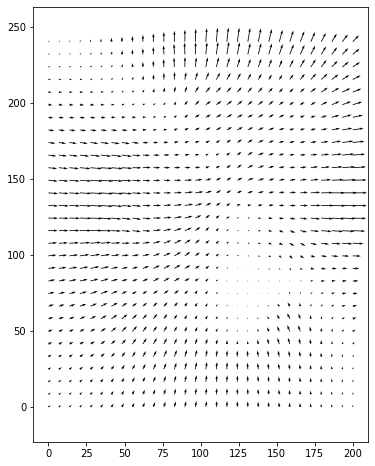

In [9]:
numSamplesX = 30
numSamplesY = 30                   
coordsX = np.linspace(0, 200, numSamplesX)
coordsY = np.linspace(0, 240, numSamplesY)
XX, YY = np.meshgrid(coordsX, coordsY)

# Transform points and compute deformation vectors.
pointsX = np.zeros(XX.shape)
pointsY = np.zeros(XX.shape)
for index, value in np.ndenumerate(XX):
    px,py = tx.TransformPoint((value, YY[index]))
    pointsX[index]=px - value 
    pointsY[index]=py - YY[index]

plt.figure(figsize=(6,8))
plt.quiver(XX, YY, pointsX, pointsY)  
plt.axis('equal')

## Artificial Image Demo

### Diffeomorphic Transform Using Demons Registration

TypeError: Invalid shape (151, 151, 151) for image data

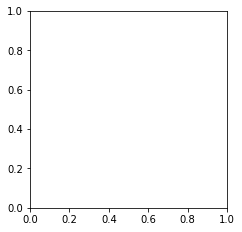

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(131)
grids = np.zeros(array.shape)
for i in range(50,201,15):
    grids[i:i+3, 35:186] = 255
for j in range(35,186,15):
    grids[50:203, j:j+3] = 255
plt.imshow(grids, cmap='gray')
plt.title('Fixed')

fixed = sitk.GetImageFromArray(grids)
resample = sitk.ResampleImageFilter()
# resample.UseReferenceImage('on')
resample.SetReferenceImage(fixed)
resample.SetInterpolator(sitk.sitkLinear)  
resample.SetTransform(tx)
moving = resample.Execute(fixed)

plt.subplot(132)
array = sitk.GetArrayFromImage(moving)
plt.imshow(array, cmap='gray')
plt.title('Deformed')

plt.subplot(133)
t0 = time()
resampled_moving = DemonsRegistration(fixed, moving, 1000, 3.0)
print('Registration process:',time()-t0,'s')
array = sitk.GetArrayFromImage(resampled_moving)
plt.imshow(array, cmap='gray')
plt.title('Reconstructed')

## Translation Using Rigid Registration
### Grids lead to a total failure to recovery translation. The algorithm proved to be effective for other images like blocks and brain images. But when applying tranlation and diffeomorphic transform to grids, the registration works. Still need more investigate.

Translaion: 4.960796011772124 -4.960796011751619
Registration process: 0.04999113082885742 s


Text(0.5, 1.0, 'Resampled Moving')

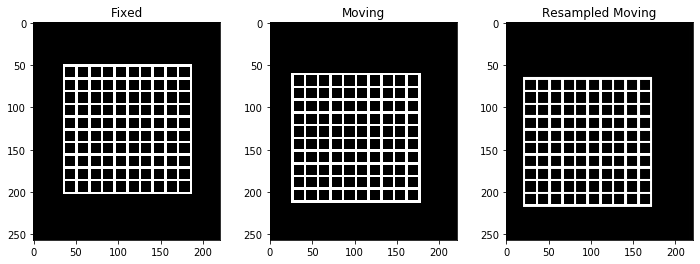

In [40]:
plt.figure(figsize=(12,4))
plt.subplot(131)
grids = np.zeros(array.shape, dtype='float32')
for i in range(50,201,15):
    grids[i:i+3, 35:186] = 255
for j in range(35,186,15):
    grids[50:203, j:j+3] = 255
plt.imshow(grids, cmap='gray')
plt.title('Fixed')

plt.subplot(132)
translate = np.zeros(array.shape, dtype='float32')
for i in range(60,211,15):
    translate[i:i+3, 25:176] = 255
for j in range(25,176,15):
    translate[60:213, j:j+3] = 255
plt.imshow(translate, cmap='gray')
plt.title('Moving')

moving = sitk.GetImageFromArray(translate)
fixed = sitk.GetImageFromArray(grids)

plt.subplot(133)
t0 = time()
resampled_moving = RigidRegistration(grids, translate, 200)
# resampled_moving = RigidRegistration2(fixed, moving, 500)
# resampled_moving = DemonsRegistration(fixed, moving, 900, 3)
print('Registration process:',time()-t0,'s')
# array = sitk.GetArrayFromImage(resampled_moving)
# plt.imshow(array, cmap='gray')
plt.imshow(resampled_moving, cmap='gray')
plt.title('Resampled Moving')


Translaion: 0.0 50.00000000000001
Registration process: 0.06122636795043945 s


Text(0.5, 1.0, 'Resampled Moving')

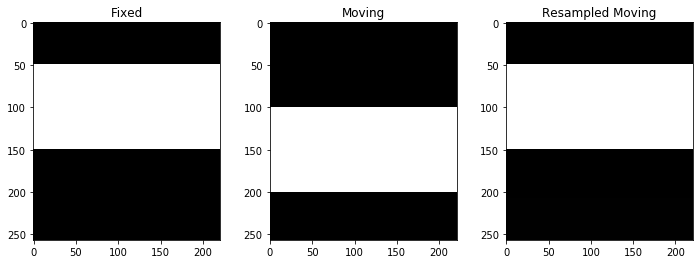

In [24]:
plt.figure(figsize=(12,4))
plt.subplot(131)
rectange = np.zeros(array.shape, dtype='float32')
rectange[50:150, :] = 255
plt.imshow(rectange, cmap='gray')
plt.title('Fixed')

plt.subplot(132)
translate = np.zeros(array.shape, dtype='float32')
translate[100:200, :] = 255
plt.imshow(translate, cmap='gray')
plt.title('Moving')

moving = sitk.GetImageFromArray(translate)
fixed = sitk.GetImageFromArray(rectange)

plt.subplot(133)
t0 = time()
resampled_moving = RigidRegistration(rectange, translate, 20)
# resampled_moving = DemonsRegistration(fixed, moving, 800, 0.8)
print('Registration process:',time()-t0,'s')
# array = sitk.GetArrayFromImage(resampled_moving)
plt.imshow(resampled_moving, cmap='gray')
plt.title('Resampled Moving')

## Translation + Diffeomorphic Transform, Using Rigid + Demons Registration

Translaion: 1.3410044599450314e-06 14.624999999999877
Rigid Registration process: 0.05453634262084961 s
Demons Registration process: 16.637770891189575 s


Text(0.5, 1.0, 'Resampled Moving')

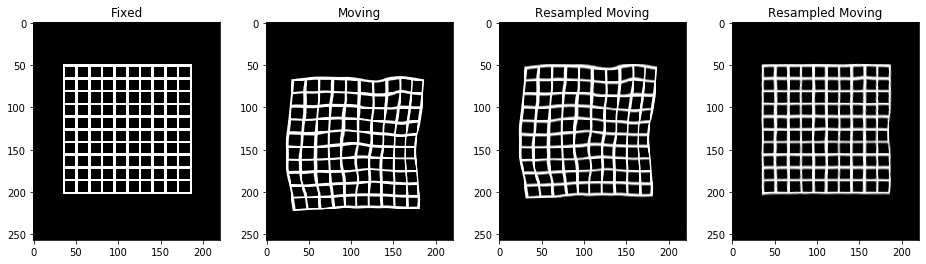

In [44]:
plt.figure(figsize=(16,4))
plt.subplot(141)
grids = np.zeros(array.shape, dtype='float32')
for i in range(50,201,15):
    grids[i:i+3, 35:186] = 255
for j in range(35,186,15):
    grids[50:203, j:j+3] = 255
plt.imshow(grids, cmap='gray')
plt.title('Fixed')

fixed = sitk.GetImageFromArray(grids)
resample = sitk.ResampleImageFilter()
# resample.UseReferenceImage('on')
resample.SetReferenceImage(fixed)
resample.SetInterpolator(sitk.sitkLinear)  
resample.SetTransform(tx)
moving = resample.Execute(fixed)
array = sitk.GetArrayFromImage(moving)
translate = np.zeros(array.shape, dtype='float32')
translate[20:, :] = array[:-20, :]
moving = sitk.GetImageFromArray(translate)

plt.subplot(142)
array = sitk.GetArrayFromImage(moving)
plt.imshow(array, cmap='gray')
plt.title('Moving')

plt.subplot(143)
t0 = time()
resampled_moving = RigidRegistration(rectange, translate, 200)
print('Rigid Registration process:',time()-t0,'s')
plt.imshow(resampled_moving, cmap='gray')
plt.title('Resampled Moving')

plt.subplot(144)
t0 = time()
resampled_moving = sitk.GetImageFromArray(resampled_moving)
resampled_moving = DemonsRegistration(fixed, resampled_moving, 800, 3)
print('Demons Registration process:',time()-t0,'s')
array = sitk.GetArrayFromImage(resampled_moving)
plt.imshow(array, cmap='gray')
plt.title('Resampled Moving')


Translaion: -11.846084241838428 18.09007218311975
Rigid Registration process: 0.09424376487731934 s
Demons Registration process: 8.036081075668335 s


Text(0.5, 1.0, 'Resampled Moving')

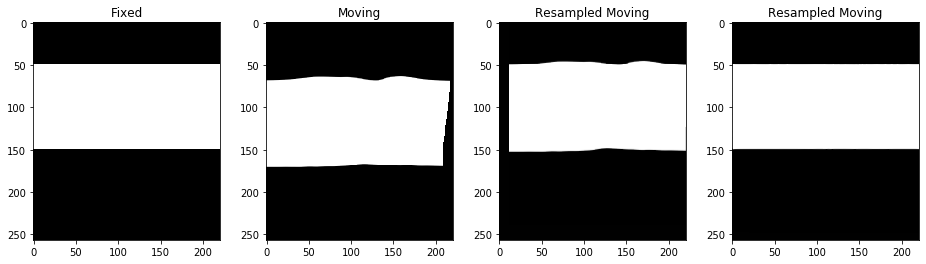

In [25]:
plt.figure(figsize=(16,4))
plt.subplot(141)
rectange = np.zeros(array.shape, dtype='float32')
rectange[50:150, :] = 255
plt.imshow(rectange, cmap='gray')
plt.title('Fixed')

fixed = sitk.GetImageFromArray(rectange)
resample = sitk.ResampleImageFilter()
# resample.UseReferenceImage('on')
resample.SetReferenceImage(fixed)
resample.SetInterpolator(sitk.sitkLinear)  
resample.SetTransform(tx)
moving = resample.Execute(fixed)
array = sitk.GetArrayFromImage(moving)
translate = np.zeros(array.shape, dtype='float32')
translate[20:, :] = array[:-20, :]
moving = sitk.GetImageFromArray(translate)

plt.subplot(142)
array = sitk.GetArrayFromImage(moving)
plt.imshow(array, cmap='gray')
plt.title('Moving')

plt.subplot(143)
t0 = time()
resampled_moving = RigidRegistration(rectange, translate, 200)
print('Rigid Registration process:',time()-t0,'s')
plt.imshow(resampled_moving, cmap='gray')
plt.title('Resampled Moving')

plt.subplot(144)
t0 = time()
resampled_moving = sitk.GetImageFromArray(resampled_moving)
resampled_moving = DemonsRegistration(fixed, resampled_moving, 400, 0.8)
print('Demons Registration process:',time()-t0,'s')
array = sitk.GetArrayFromImage(resampled_moving)
plt.imshow(array, cmap='gray')
plt.title('Resampled Moving')


## 3D Artificial Images Demo

In [12]:
def cube_generator(center, radius):
    sphere = np.zeros([151,151,151], dtype='float32')
    sphere[center[0]-radius//2:center[0]+radius//2, center[1]-radius:center[1]+radius, center[2]-radius:center[2]+radius]=255
    return sphere

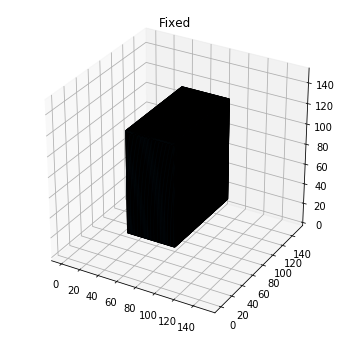

In [15]:
from mpl_toolkits.mplot3d import Axes3D
cube = cube_generator([75,75,75], 50)
fig =plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.voxels(cube, edgecolor='k')
plt.title('Fixed')
plt.show()

In [13]:
cube = cube_generator([75,75,75], 50)
fixed = sitk.GetImageFromArray(cube)
moving = sitk.GetImageFromArray(cube_generator([90,75,75], 50))
resampled_moving, tx_3d = DemonsRegistration3D(fixed, moving, 1500, 0.8, True)

Difference:  2193221.2


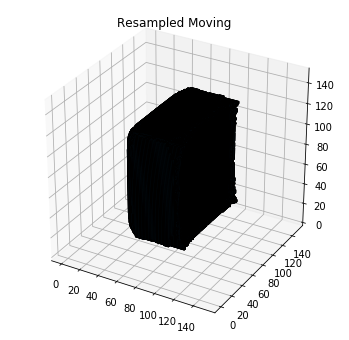

In [16]:
fixed = sitk.GetImageFromArray(cube)
moving = sitk.GetImageFromArray(cube_generator([90,75,75], 50))
resampled_moving, tx_3d = DemonsRegistration3D(fixed, moving, 1500, 0.8, True)
array = sitk.GetArrayFromImage(resampled_moving)
print('Difference: ', str(np.abs(array-cube).sum()))
fig =plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.voxels(array, edgecolor='k')
plt.title('Resampled Moving')
plt.show()

In [25]:
t0 = time()
translate = cube_generator([60,50,50], 30)
resampled_moving2 = RigidRegistration(cube, translate, 200)
print(time()-t0)
print('Difference: ', str(np.abs(resampled_moving2-cube).sum()))
fig =plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.voxels(resampled_moving2, edgecolor='k')
plt.title('Resampled Moving')
plt.show()

<class 'itkImagePython.itkImageF3'> <class 'itkImagePython.itkImageF3'>


TypeError: in method 'itkImageRegistrationMethodv4REGv4F2F2_SetFixedImage', argument 2 of type 'itkImageF2 const *'

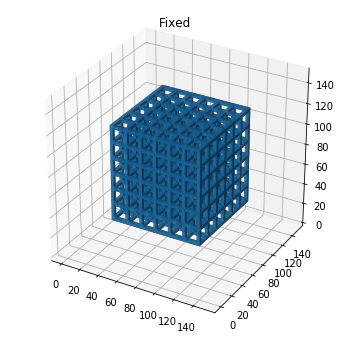

In [12]:
from mpl_toolkits.mplot3d import Axes3D
grids = np.zeros([151,151,151])
for i in range(30,121,15):
    for j in range(30,121,15):
        grids[i:i+3, j:j+3, 30:123] = 1
for i in range(30,121,15):
    for j in range(30,121,15):
        grids[i:i+3, 30:123, j:j+3] = 1
for i in range(30,121,15):
    for j in range(30,121,15):
        grids[30:123, i:i+3, j:j+3] = 1
fig =plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.voxels(grids)
plt.title('Fixed')
plt.show()

Difference:  143084.2014674652


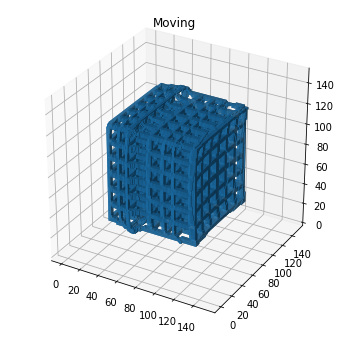

In [17]:
fixed = sitk.GetImageFromArray(grids)
resample = sitk.ResampleImageFilter()
# resample.UseReferenceImage('on')
resample.SetReferenceImage(fixed)
resample.SetInterpolator(sitk.sitkLinear)  
resample.SetTransform(tx_3d)
moving = resample.Execute(fixed)
array = sitk.GetArrayFromImage(moving)
print('Difference: ', str(np.abs(array-grids).sum()))
fig =plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.voxels(array)
plt.title('Moving')
plt.show()

In [14]:
fixed = sitk.GetImageFromArray(grids)
resample = sitk.ResampleImageFilter()
# resample.UseReferenceImage('on')
resample.SetReferenceImage(fixed)
resample.SetInterpolator(sitk.sitkLinear)  
resample.SetTransform(tx_3d)
moving = resample.Execute(fixed)

Difference:  48397.4487419575


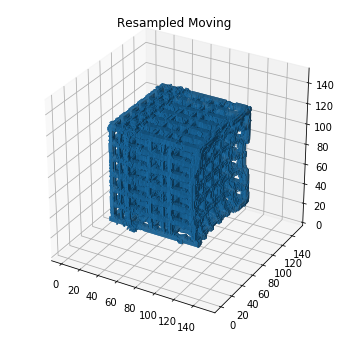

In [15]:
resampled_moving = DemonsRegistration3D(fixed, moving, 800, 0.5)
array = sitk.GetArrayFromImage(resampled_moving)
print('Difference: ', str(np.abs(array-grids).sum()))
fig =plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.voxels(array)
plt.title('Resampled Moving')
plt.show()

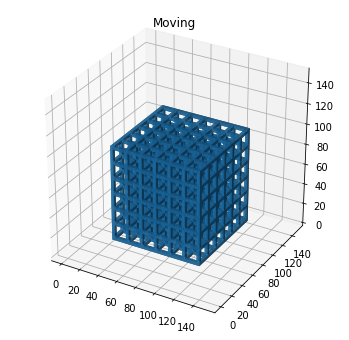

In [47]:
translate = np.zeros([151,151,151])
for i in range(30,121,15):
    for j in range(30,121,15):
        translate[i:i+3, j:j+3, 10:103] = 1
for i in range(30,121,15):
    for j in range(10,101,15):
        translate[i:i+3, 30:123, j:j+3] = 1
for i in range(30,121,15):
    for j in range(10,101,15):
        translate[30:123, i:i+3, j:j+3] = 1
fig =plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.voxels(translate)
plt.title('Moving')
plt.show()

Difference:  100396.08033701134


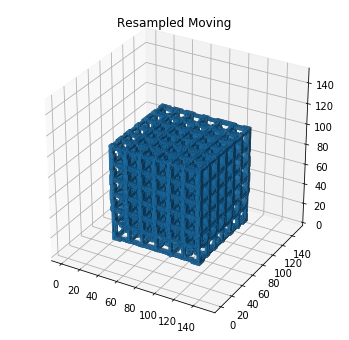

In [52]:
fixed = sitk.GetImageFromArray(grids)
moving = sitk.GetImageFromArray(translate)
resampled_moving = DemonsRegistration3D(fixed, moving, 800, 0.8)
array = sitk.GetArrayFromImage(resampled_moving)
print('Difference: ', str(np.abs(array-grids).sum()))
fig =plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.voxels(array)
plt.title('Resampled Moving')
plt.show()

122.39017581939697
Difference:  22269.442227293748


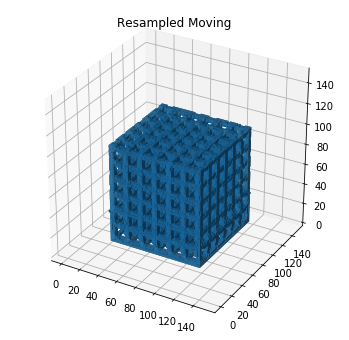

In [50]:
t0 = time()
resampled_moving2 = DemonsRegistration3D(moving, resampled_moving, 1500, 0.8)
print(time()-t0)
array = sitk.GetArrayFromImage(resampled_moving2)
print('Difference: ', str(np.abs(array-translate).sum()))
fig =plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')
ax.voxels(array)
plt.title('Resampled Moving')
plt.show()

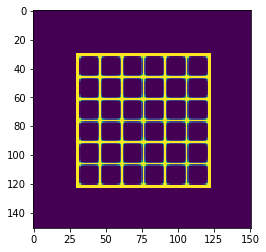

In [51]:
array = sitk.GetArrayFromImage(resampled_moving)
plt.imshow(array[:,:,85])